In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import riskfolio.RiskFunctions as rf
import matplotlib as plt
import  statsmodels .api  as  sm 
from  sklearn.linear_model  import  LinearRegression
import  cvxpy  as  cv
from scipy.stats import norm

from finquant.portfolio import *
from finquant.moving_average import compute_ma, ema

import quantstats as qs

In [2]:
df_health = pd.read_csv('tick_score_health.csv')
df_tech = pd.read_csv('tick_score_tech.csv')
df_durable = pd.read_csv('tick_score_durable.csv')
df_nondurable = pd.read_csv('tick_score_nondurable.csv')
df_capital = pd.read_csv('tick_score_capital.csv')
df_transport = pd.read_csv('tick_score_transport.csv')
df_util = pd.read_csv('tick_score_util.csv')
df_services = pd.read_csv('tick_score_services.csv')
df_energy = pd.read_csv('tick_score_energy.csv')
df_finance = pd.read_csv('tick_score_finance.csv')
df_basics = pd.read_csv('tick_score_basics.csv')


frames = [df_finance, df_capital, df_durable, df_energy, df_health, df_nondurable, df_services, df_tech, df_services, df_util, df_basics]
df = pd.concat(frames)
df = df.drop_duplicates(subset=['Unnamed: 0'], keep='last')
df = df.set_index("Unnamed: 0")

percentile = np.percentile(df['Score'], 90)
mu, std = norm.fit(df['Score'])
roc = std / 3
aplus = df[df['Score'] > mu + (roc*4)]
#aplus = df[df['Score'] > mu + (roc*6)]
tickers = aplus.index

In [3]:
start = "2016-01-01"
end = "2020-12-30"

# Tickers of assets
assets = list(tickers)
assets.sort()

In [4]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

market_data = yf.download("^GSPC", start = start, end = end, threads = False)
market_data = market_data.loc[:,('Adj Close')]

[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
port_diff = data[assets].pct_change().dropna()
mkt_diff = market_data.pct_change().dropna()

In [6]:
################################################## ####################### 
# Calculating the Betas 
######################## ################################################ 

# Using statsmodels 
x = mkt_diff.values 
x = sm.add_constant(x)

Beta_1  =  [] 
for i in assets:
    y_i =  port_diff[i].values 
    mod =  sm.OLS(y_i, x) 
    res =  mod.fit() 
    Beta_1.append(res.params[1])

Beta_1 = np.matrix(Beta_1)

# Using scikit learn 
y = port_diff.values 
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
reg = LinearRegression().fit(x, y)
Beta_2 = np.matrix(reg.coef_).T

# Combining both betas to show them 
B1 = pd.DataFrame(Beta_1.T, index = assets, columns = ['Beta_1']) 
B2 = pd.DataFrame(Beta_2.T, index = assets, columns = ['Beta_2'])

B1_B2 = pd.concat([B1, B2], axis = 1)


In [7]:
################################################## ####################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
########### ################################################## ###########

Sigma_rm = np.matrix(np.var(mkt_diff, ddof = 1))

x = mkt_diff.values 
x = sm.add_constant(x)

mu_F_1 = []
Sigma_e_1 = []
for i in assets:
    y_i = port_diff[i].values
    mod = sm.OLS(y_i, x)
    res = mod.fit()
    error = np.matrix(y_i) - np.matrix(res.predict(x))
    mu_F_1.append(np.mean(res.predict(x), axis = 0))
    Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))

mu_F_1 = np.matrix(mu_F_1)
Sigma_e_1 = np.diag(Sigma_e_1)
Sigma_F_1 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_1

#display(pd.DataFrame(mu_F_1, columns = assets))
#display(pd.DataFrame(Sigma_F_1, index = assets, columns = assets))

<ipython-input-7-521761541ad5>:19: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))


In [8]:
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
error_2 = y - reg.predict(x)

mu_F_2 = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_e_2 = np.diag(np.var(error_2, ddof = 1, axis = 0))
Sigma_F_2 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_2

#display(pd.DataFrame(mu_F_2, columns = assets))
#display(pd.DataFrame(Sigma_F_2, index = assets, columns = assets))

In [27]:
################################################## ###################### 
# Calculating optimal portfolios with historical estimates 
# and CAPM estimates 
############# ################################################## #########

# Defining the optimization function 
def Max_Sharpe(mu, Sigma):
    w = cv.Variable((mu.shape[1], 1))
    k = cv.Variable(1)
    rf = cv.Parameter(nonneg=True)
    #rf = 0.36
    
    rf.value=0
    #print(rf.value)
    rf.value = 0.36 / 1260
    #defining the problem, objective function and    
    constraints = [(mu - rf)*w == 1,
                   w >= 1e-10,
                   k >= 1e-10,
                   cv.sum(w) == k]
    prob = cv.Problem(cv.Minimize(cv.quad_form(w, Sigma)), constraints)
    #solving the problem
    prob.solve(solver=cv.ECOS)

    return np.matrix(w.value/k.value)

mu = np.matrix(np.mean(port_diff.values, axis = 0))
Sigma = np.cov(port_diff.values.T)

w1 = Max_Sharpe(mu, Sigma)
w2 = Max_Sharpe(mu_F_2, Sigma_F_2)



W1 = pd.DataFrame(w1, index = assets, columns = ['Historical'])
W2 = pd.DataFrame(w2, index = assets, columns = ['CAPM'])

#display(pd.concat([W1, W2], axis = 1).applymap("{0:.2%}".format))

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 22 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 23 times so far.

  warnings.w

In [28]:
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import matplotlib as plt

In [29]:
W2_dup = W2.reset_index()
W2_dup.columns = ["Name", "Allocation"]
print(W2_dup)
df_pf_CAPM = build_portfolio(names=list(W2.index), start_date = start, end_date = end, data_api="yfinance", pf_allocation = W2_dup)
df_pf_CAPM.freq = 1260
df_pf_CAPM.risk_free_rate = 0.36
print(f"Sharpe Ratio: {df_pf_CAPM.comp_sharpe()}")


    Name    Allocation
0   ABBV  2.879122e-08
1    APD  2.057561e-08
2    AZO  1.381182e-08
3     BA  7.292756e-09
4    BCE  1.057202e-08
5    BEN  4.556286e-09
6   BKNG  9.524264e-09
7    BTI  6.680409e-09
8     CL  1.288631e-08
9    CLX  3.262465e-02
10   CMI  2.005656e-08
11     D  1.070254e-08
12   DEO  1.497620e-08
13   DPZ  2.362050e-01
14   DVN  3.432627e-09
15    EL  5.847177e-02
16   EMR  9.645018e-09
17   EOG  4.367545e-09
18  FANG  4.936024e-09
19  GILD  5.371559e-09
20   HCA  2.320575e-08
21   HON  1.564301e-08
22  IDXX  4.703595e-01
23   IFF  6.466358e-09
24   IHG  8.724471e-09
25   IQV  1.718659e-08
26   JHX  2.043952e-08
27   KDP  9.014850e-02
28   KEP  4.762955e-09
29   KMB  1.118042e-08
30    KO  1.173443e-08
31   LIN  3.204200e-08
32   LNG  1.119476e-08
33   LYB  5.646074e-09
34   MCO  1.948078e-08
35  MDLZ  9.598485e-09
36   MTD  9.451441e-02
37   NGG  8.511694e-09
38   OXY  2.829817e-09
39   PEP  1.384825e-08
40    PM  8.356220e-09
41   PPG  9.076661e-09
42   PSX  5

[*********************100%***********************]  4 of 4 completed


PRWAX    66.169272
SWPPX    83.268981
WFIVX    42.547109
^GSPC    85.179811
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2016-01-05   99.975533  100.193048  100.171335  100.201223
2016-01-06   99.021523   98.938224   98.914903   98.887044
2016-01-07   96.061642   96.589448   96.516273   96.543377
2016-01-08   95.009783   95.527672   95.431176   95.497004
2016-01-11   94.863008   95.624194   95.431176   95.578489
...                ...         ...         ...         ...
2020-12-22  164.995096  181.306302  143.061102  183.203320
2020-12-23  165.092945  181.435005  143.232436  183.339955
2020-12-24  165.166328  182.110678  143.632206  183.988354
2020-12-28  166.071423  183.687260  144.545969  185.593197
2020-12-29  166.169272  183.268981  142.547109  185.179811

[1256 rows x 4 columns]

Date
2016-01-05    100.897650
2016-01-06    100.228203
2016-01-07     97.987484
2016-01-08     97.797742
2016-01-11     96.759629
                 ...    
2020-12-22    512.537990
2020-12-23    512.431054
2020-12-24    513.375379
2020-12-28    513.417954
2020-12-29    508.403676
Length: 1256, dtype: float64


<AxesSubplot:xlabel='Date'>

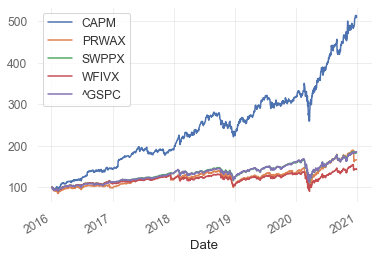

In [30]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end=end, threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[assets].pct_change().fillna(0)[1:]
for tick in W2.index:
    Y_cum.loc[:,tick] *= W2.loc[tick].values
port_ret = Y_cum.sum(axis=1)
Y_cum_ret = (port_ret + 1).cumprod()
Y_cum_ret *= 100
print(Y_cum_ret)



pfcr = pd.DataFrame(Y_cum_ret)
pfcr.columns = ["CAPM"]
newdf = pfcr.join(compare_port)

newdf.plot()

In [31]:
qs.stats.sharpe(port_ret, rf=0.36, periods=1260)

3.0413905363403764

In [32]:
################################################## ###################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
############ ################################################## ###########

# Loading the information of the factors 
#dt.date
three_factor = pd.read_csv('FF_three.csv', index_col=0, header=0)/100
three_factor = three_factor.loc[start: end][:-2]
x = three_factor[['Mkt-RF', 'SMB', 'HML']].values
#display(three_factor)
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

In [33]:
Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))

In [34]:
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2

In [35]:
w_fama_three = Max_Sharpe(mu_fama, Sigma_fama)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 24 times so far.

  warnings.warn(msg, UserWarning)


In [36]:
W3 = pd.DataFrame(w_fama_three, index = assets, columns = ['Fama Three'])

In [37]:
W3_dup = W3.reset_index()
W3_dup.columns = ["Name", "Allocation"]
df_pf_fama3 = build_portfolio(names=list(W3.index), start_date = start, end_date = end, data_api="yfinance", pf_allocation = W3_dup)
df_pf_fama3.freq = 1260
df_pf_fama3.risk_free_rate = 0.36
print(f"Sharpe Ratio: {df_pf_fama3.comp_sharpe()}")

#df_pf_fama3.properties()

[*********************100%***********************]  48 of 48 completed
Sharpe Ratio: 2.138016737388893


[*********************100%***********************]  4 of 4 completed


PRWAX    66.169272
SWPPX    83.268981
WFIVX    42.547109
^GSPC    85.179811
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2016-01-05   99.975533  100.193048  100.171335  100.201223
2016-01-06   99.021523   98.938224   98.914903   98.887044
2016-01-07   96.061642   96.589448   96.516273   96.543377
2016-01-08   95.009783   95.527672   95.431176   95.497004
2016-01-11   94.863008   95.624194   95.431176   95.578489
...                ...         ...         ...         ...
2020-12-22  164.995096  181.306302  143.061102  183.203320
2020-12-23  165.092945  181.435005  143.232436  183.339955
2020-12-24  165.166328  182.110678  143.632206  183.988354
2020-12-28  166.071423  183.687260  144.545969  185.593197
2020-12-29  166.169272  183.268981  142.547109  185.179811

[1256 rows x 4 columns]

Date
2016-01-05    100.171157
2016-01-06     99.000364
2016-01-07     96.428938
2016-01-08     95.464874
2016-01-11     95.260575
                 ...    
2020-12-22    332.780622
2020-12-23    333.229589
2020-12-24    334.631112
2020-12-28    335.324943
2020-12-29    335.156217
Length: 1256, dtype: float64


<AxesSubplot:xlabel='Date'>

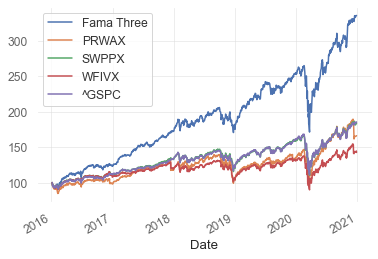

In [38]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end=end, threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[assets].pct_change().fillna(0)[1:]
for tick in W3.index:
    Y_cum.loc[:,tick] *= W3.loc[tick].values
port_ret = Y_cum.sum(axis=1)
Y_cum_ret = (port_ret + 1).cumprod()
Y_cum_ret *= 100
print(Y_cum_ret)



pfcr = pd.DataFrame(Y_cum_ret)
pfcr.columns = ["Fama Three"]
newdf = pfcr.join(compare_port)

newdf.plot()

In [39]:
qs.stats.sharpe(port_ret, rf=0.36, periods=1260)

2.2556894672309555

In [40]:
five_factor = pd.read_csv('FF_five.csv', index_col=0, header=0)/100
five_factor = five_factor.loc[start: end][:-2]
x = five_factor[['Mkt-RF', 'SMB', 'HML', 'RMW','CMA']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

In [41]:
Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2
w_fama_five = Max_Sharpe(mu_fama, Sigma_fama)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 25 times so far.

  warnings.warn(msg, UserWarning)


In [42]:
W4 = pd.DataFrame(w_fama_five, index = assets, columns = ['Fama Five'])

In [43]:
W4_dup = W4.reset_index()
W4_dup.columns = ["Name", "Allocation"]
df_pf_fama5 = build_portfolio(names=list(W4.index), start_date = start, end_date = end, data_api="yfinance", pf_allocation = W4_dup)
df_pf_fama5.freq = 1260
df_pf_fama5.risk_free_rate = 0.36
print(f"Sharpe Ratio: {df_pf_fama5.comp_sharpe()}")
#df_pf_fama5.properties()

[*********************100%***********************]  48 of 48 completed
Sharpe Ratio: 2.1980023607347423


[*********************100%***********************]  4 of 4 completed


PRWAX    66.169272
SWPPX    83.268981
WFIVX    42.547109
^GSPC    85.179811
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2016-01-05   99.975533  100.193048  100.171335  100.201223
2016-01-06   99.021523   98.938224   98.914903   98.887044
2016-01-07   96.061642   96.589448   96.516273   96.543377
2016-01-08   95.009783   95.527672   95.431176   95.497004
2016-01-11   94.863008   95.624194   95.431176   95.578489
...                ...         ...         ...         ...
2020-12-22  164.995096  181.306302  143.061102  183.203320
2020-12-23  165.092945  181.435005  143.232436  183.339955
2020-12-24  165.166328  182.110678  143.632206  183.988354
2020-12-28  166.071423  183.687260  144.545969  185.593197
2020-12-29  166.169272  183.268981  142.547109  185.179811

[1256 rows x 4 columns]

Date
2016-01-05    100.181761
2016-01-06     99.033123
2016-01-07     96.503913
2016-01-08     95.510221
2016-01-11     95.279115
                 ...    
2020-12-22    340.901313
2020-12-23    341.144909
2020-12-24    342.690326
2020-12-28    343.348510
2020-12-29    343.078112
Length: 1256, dtype: float64


<AxesSubplot:xlabel='Date'>

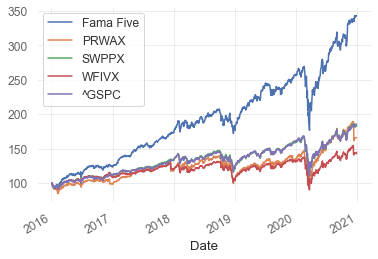

In [44]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end=end, threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[assets].pct_change().fillna(0)[1:]
for tick in W4.index:
    Y_cum.loc[:,tick] *= W4.loc[tick].values
port_ret = Y_cum.sum(axis=1)
Y_cum_ret = (port_ret + 1).cumprod()
Y_cum_ret *= 100
print(Y_cum_ret)



pfcr = pd.DataFrame(Y_cum_ret)
pfcr.columns = ["Fama Five"]
newdf = pfcr.join(compare_port)

newdf.plot()

In [45]:
qs.reports.html(port_ret, output='stats_fama_five.html', title='Fama Five', rf=0.36)

In [46]:
qs.stats.sharpe(port_ret, rf=0.36, periods=1260)

2.3161753029243766

In [47]:
qs.stats.max_drawdown(port_ret)

-0.3444704094501555

In [48]:
qs.stats.cagr(port_ret, rf=0.36)

-1.0